In [14]:
import pandas as pd
import numpy as np
np.random.seed(10)

In [15]:
import sys
project_root = '../../src/'
sys.path.insert(0, project_root)

In [16]:
user_data = pd.read_csv('../../datasets/seven_day_listening_history.csv')
print(user_data.head())

   duration (ms)  danceability  energy  loudness  speechiness  acousticness  \
0       125036.0      0.682982  0.4480  0.454525     0.582207      0.844378   
1       251480.0      0.884331  0.5360  0.580489     0.582207      0.048293   
2       129962.0      0.832923  0.5750  0.392388     0.582207      0.018976   
3       219333.0      0.358466  0.0525  0.467604     0.735099      0.897590   
4       175733.0      0.716183  0.2920  0.535565     0.582207      0.292169   

   instrumentalness  liveness  valence     tempo     spec_rate  labels  \
0          0.000000  0.188416    0.579  0.825227  4.754654e-07     0.0   
1          0.000135  0.179196    0.744  0.601342  7.754096e-07     1.0   
2          0.004970  0.447321    0.621  0.664681  4.754654e-07     2.0   
3          0.177000  0.447321    0.036  0.561521  5.060798e-07     0.0   
4          0.000748  0.546099    0.524  0.293744  4.754654e-07     0.0   

                                    uri  user_id  group_no  day  
0  spotify:tra

In [17]:
from scipy.sparse.linalg import svds

def create_user_item_matrix(df):
    """
    Step 1: Create the user-item matrix
    - Rows represent users
    - Columns represent songs (items)
    - Values represent the interaction score
    """
    # First, let's create an interaction score based on the features
    feature_columns = [
        'danceability', 'energy', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration (ms)', 'spec_rate', 'labels'
    ]
    
    # Create an interaction score (average of normalized features)
    df['interaction_score'] = np.mean(df[feature_columns], axis=1)
    
    # Create the user-item matrix
    user_item_matrix = df.pivot_table(
        index='user_id',
        columns='uri',
        values='interaction_score',
        fill_value=0
    )
    
    return user_item_matrix

In [18]:

def perform_svd(matrix, k=10):
    """
    Step 2: Perform SVD on the matrix
    - Decompose matrix into U, Sigma, and V matrices
    - k is the number of latent factors
    """
    # Convert to numpy array
    matrix_numpy = matrix.values
    
    # Center the matrix (subtract mean)
    matrix_mean = np.mean(matrix_numpy, axis=1)
    matrix_centered = matrix_numpy - matrix_mean.reshape(-1, 1)
    
    # Perform SVD
    U, sigma, Vt = svds(matrix_centered, k=k)
    
    # Convert sigma to diagonal matrix
    sigma = np.diag(sigma)
    
    return U, sigma, Vt, matrix_mean

def reconstruct_matrix(U, sigma, Vt, matrix_mean):
    """
    Step 3: Reconstruct the matrix to get predictions
    - Multiply U, sigma, and V transpose
    - Add back the mean
    """
    # Reconstruct the matrix
    predictions = np.dot(np.dot(U, sigma), Vt)
    
    # Add the mean back
    predictions += matrix_mean.reshape(-1, 1)
    
    return predictions

def get_recommendations(predictions, user_item_matrix, user_id, n_recommendations=5):
    """
    Step 4: Generate recommendations for a user
    - Find songs the user hasn't interacted with
    - Rank them by predicted score
    """
    # Get user index
    user_idx = user_item_matrix.index.get_loc(user_id)
    
    # Get song indices and names
    song_indices = np.arange(user_item_matrix.shape[1])
    song_names = user_item_matrix.columns
    
    # Get user's predictions
    user_predictions = predictions[user_idx]
    
    # Get indices of songs user hasn't interacted with
    user_songs = user_item_matrix.iloc[user_idx].values
    unlistened_songs = song_indices[user_songs == 0]
    
    # Get predictions for unlistened songs
    unlistened_predictions = user_predictions[unlistened_songs]
    
    # Get top N recommendations
    top_n_idx = np.argsort(unlistened_predictions)[-n_recommendations:][::-1]
    recommended_song_indices = unlistened_songs[top_n_idx]
    recommended_songs = song_names[recommended_song_indices]
    
    return recommended_songs, user_predictions[recommended_song_indices]

In [19]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set up Spotify API credentials
client_id = '75d0ab19dcdc4db7821a27bf07df72a0'  # Replace with your Spotify client ID
client_secret = 'f64897e446834d7cb83b1c90916242df'  # Replace with your Spotify client secret

# Authenticate with Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to extract song name from Spotify URL
def get_song_names_from_url(song_urls):
    song_names = []
    for i in range(len(song_urls)):
        track_id = song_urls[i].split("/")[-1].split("?")[0]  # Extract the track ID from the URL
        track_info = sp.track(track_id)  # Get track information
        song_name = track_info['name']  # Extract song name
        artist_name = track_info['artists'][0]['name']  # Extract artist name
        song_names.append(f"{song_name} by {artist_name}")
    return song_names



In [20]:
from constants.constants import group_mood_mapping

def main_svd_pipeline(df, n_factors=10):
    """
    Run the complete SVD pipeline
    """
    # Step 1: Create user-item matrix
    print("Creating user-item matrix...")
    user_item_matrix = create_user_item_matrix(df)
    print(f"Matrix shape: {user_item_matrix.shape}")
    
    # Step 2: Perform SVD
    print("\nPerforming SVD...")
    U, sigma, Vt, matrix_mean = perform_svd(user_item_matrix, k=n_factors)
    print(f"U shape: {U.shape}")
    print(f"Sigma shape: {sigma.shape}")
    print(f"V^T shape: {Vt.shape}")
    
    # Step 3: Generate predictions
    print("\nGenerating predictions...")
    predictions = reconstruct_matrix(U, sigma, Vt, matrix_mean)
    
    return user_item_matrix, predictions

# Example usage
label_map = {0: 'sad', 1: 'happy', 2:'energetic', 3:'calm'}
group_mapping = {1:'sad/acoustic', 2:'happy/danceable', 3: 'energetic', 4:'calm/instrumental', 5:'mixed mood', 6:'energetic/high-tempo', 7:'calm/relaxing'}
def demonstrate_recommendations(df):
    """
    Demonstrate the recommendation system
    """
    # Run SVD pipeline
    user_item_matrix, predictions = main_svd_pipeline(df)
    
    # Get recommendations for some sample users
    sample_users = np.random.choice(user_item_matrix.index, 10)
    # i = np.random.randint(user_item_matrix.shape[0])
    # sample_user = user_item_matrix.index[i]
    print(f"\nGetting recommendations for users {sample_users}...")
    for sample_user in sample_users:
        recommended_songs, pred_scores = get_recommendations(
            predictions, 
            user_item_matrix, 
            sample_user
        )
        recc_songs_label_map = {label:0 for label in label_map.values()}
        group_user = df[df['user_id'] == sample_user].iloc[0]['group_no']
        print(f"\nUser {sample_user} belonging to group {group_mapping[group_user]} Recommendations:")
        for song, score in zip(recommended_songs, pred_scores):
            # print(f"- {song} (score: {score:.2f})")
            # print song attributes
            recc_songs_label_map[label_map[df[df['uri'] == song].iloc[0]['labels']]]+=1
        print(f"Recommended songs distribution: {recc_songs_label_map}")
    
    
    return 

In [35]:
demonstrate_recommendations(user_data)

Creating user-item matrix...
Matrix shape: (100, 82752)

Performing SVD...
U shape: (100, 10)
Sigma shape: (10, 10)
V^T shape: (10, 82752)

Generating predictions...

Getting recommendations for users [70 50 83 65 22 83 35 16 59 37]...

User 70 belonging to group energetic/high-tempo Recommendations:
Recommended songs distribution: {'sad': 0, 'happy': 5, 'energetic': 0, 'calm': 0}

User 50 belonging to group mixed mood Recommendations:
Recommended songs distribution: {'sad': 1, 'happy': 3, 'energetic': 0, 'calm': 1}

User 83 belonging to group calm/relaxing Recommendations:
Recommended songs distribution: {'sad': 0, 'happy': 2, 'energetic': 1, 'calm': 2}

User 65 belonging to group mixed mood Recommendations:
Recommended songs distribution: {'sad': 0, 'happy': 1, 'energetic': 1, 'calm': 3}

User 22 belonging to group calm/instrumental Recommendations:
Recommended songs distribution: {'sad': 0, 'happy': 1, 'energetic': 2, 'calm': 2}

User 83 belonging to group calm/relaxing Recommendati

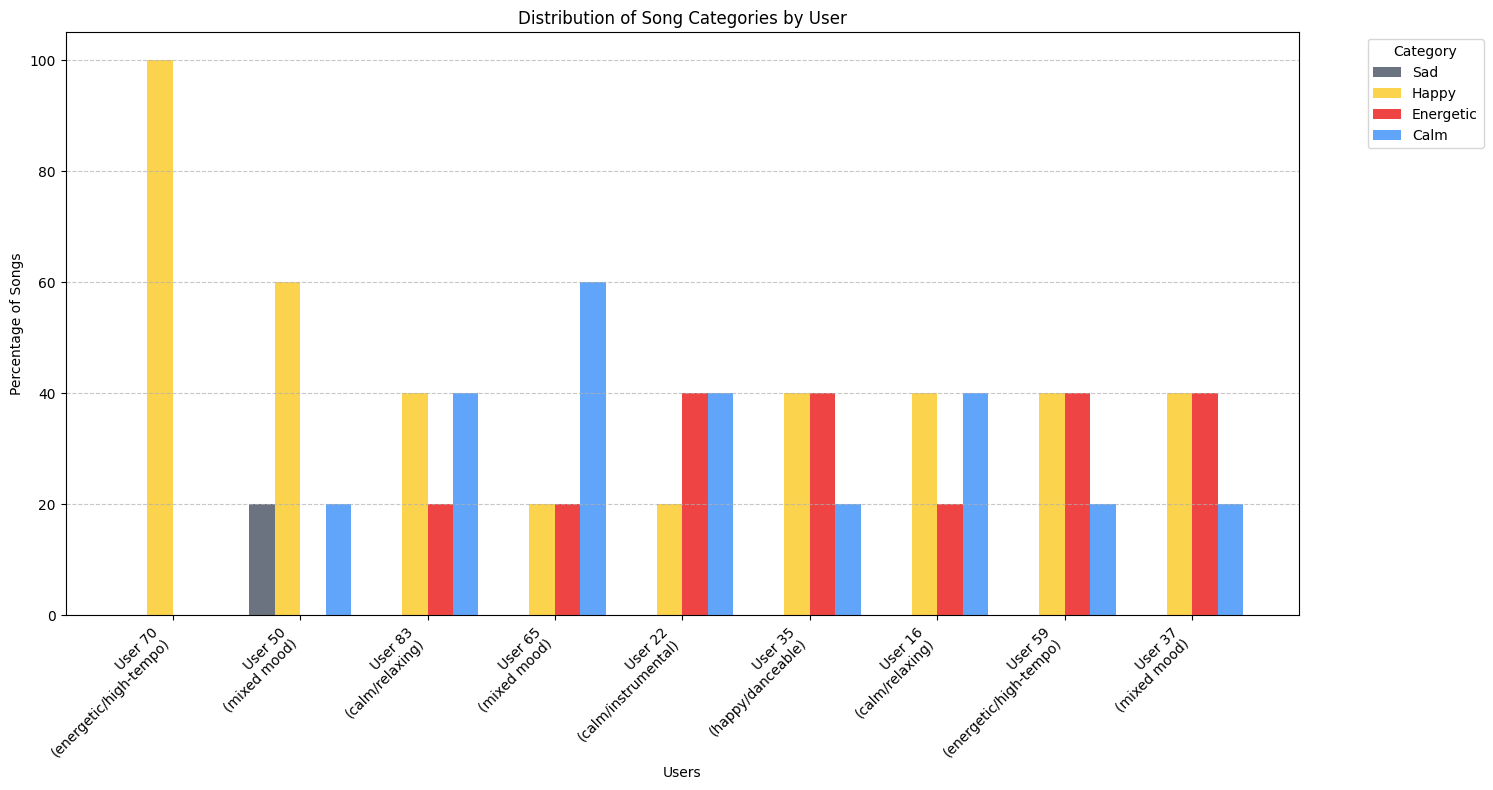


Percentage Distribution Table:
    Sad %  Happy %  Energetic %  Calm %
70    0.0    100.0          0.0     0.0
50   20.0     60.0          0.0    20.0
83    0.0     40.0         20.0    40.0
65    0.0     20.0         20.0    60.0
22    0.0     20.0         40.0    40.0
35    0.0     40.0         40.0    20.0
16    0.0     40.0         20.0    40.0
59    0.0     40.0         40.0    20.0
37    0.0     40.0         40.0    20.0


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the data dictionary
data = {
    70: {'group': 'energetic/high-tempo', 'sad': 0, 'happy': 5, 'energetic': 0, 'calm': 0},
    50: {'group': 'mixed mood', 'sad': 1, 'happy': 3, 'energetic': 0, 'calm': 1},
    83: {'group': 'calm/relaxing', 'sad': 0, 'happy': 2, 'energetic': 1, 'calm': 2},
    65: {'group': 'mixed mood', 'sad': 0, 'happy': 1, 'energetic': 1, 'calm': 3},
    22: {'group': 'calm/instrumental', 'sad': 0, 'happy': 1, 'energetic': 2, 'calm': 2},
    35: {'group': 'happy/danceable', 'sad': 0, 'happy': 2, 'energetic': 2, 'calm': 1},
    16: {'group': 'calm/relaxing', 'sad': 0, 'happy': 2, 'energetic': 1, 'calm': 2},
    59: {'group': 'energetic/high-tempo', 'sad': 0, 'happy': 2, 'energetic': 2, 'calm': 1},
    37: {'group': 'mixed mood', 'sad': 0, 'happy': 2, 'energetic': 2, 'calm': 1}
}

# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Calculate percentages
categories = ['sad', 'happy', 'energetic', 'calm']
total_songs = df[categories].sum(axis=1)
for category in categories:
    df[f'{category}_pct'] = df[category] / total_songs * 100

# Plotting
plt.figure(figsize=(15, 8))

# Set the width of each bar and positions of the bars
width = 0.2
x = np.arange(len(df))

# Create bars for each category
colors = ['#6B7280', '#FCD34D', '#EF4444', '#60A5FA']  # gray, yellow, red, blue
for i, category in enumerate(categories):
    plt.bar(x + i*width, 
           df[f'{category}_pct'], 
           width, 
           label=category.capitalize(),
           color=colors[i])

# Customize the plot
plt.xlabel('Users')
plt.ylabel('Percentage of Songs')
plt.title('Distribution of Song Categories by User')
plt.xticks(x + width*1.5, [f'User {idx}\n({row["group"]})' for idx, row in df.iterrows()], 
           rotation=45, ha='right')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print percentage distribution table
percentage_df = df[[f'{cat}_pct' for cat in categories]].round(1)
percentage_df.columns = [f'{cat.capitalize()} %' for cat in categories]
print("\nPercentage Distribution Table:")
print(percentage_df)